In [48]:
from tifffile import imread
import os
from matplotlib import pyplot as plt
import json
from scipy.io import loadmat
import h5py
import numpy as np

In [49]:
pth_tiles = r'\\10.99.68.178\andreex\students\Donald Monkey fetus\BTC\20x_Cropped'
pth_WSI_segmentations = r'\\10.99.68.178\andreex\students\Donald Monkey fetus\BTC\ndpi\StarDist_1_12_24\json'
pth_crop_tile_mat_folder = r'\\10.99.68.178\andreex\students\Donald Monkey fetus\BTC\matfiles'

In [50]:
tile_pth_list = [os.path.join(pth_tiles,file) for file in os.listdir(pth_tiles) if file.endswith(".tif")]
json_pth_list = [os.path.join(pth_WSI_segmentations,file) for file in os.listdir(pth_WSI_segmentations) if file.endswith(".json")]
crop_mat_list = [os.path.join(pth_crop_tile_mat_folder,file) for file in os.listdir(pth_crop_tile_mat_folder) if file.endswith(".mat")]  # tile cropping info in mat files folder

In [51]:
print(tile_pth_list)

['\\\\10.99.68.178\\andreex\\students\\Donald Monkey fetus\\BTC\\20x_Cropped\\H15_0277.tif']


In [52]:
print(json_pth_list)

['\\\\10.99.68.178\\andreex\\students\\Donald Monkey fetus\\BTC\\ndpi\\StarDist_1_12_24\\json\\H15_0277.json']


In [53]:
sample_names = [f.split('\\')[-1][:-4] for f in tile_pth_list]
sample_names

['H15_0277']

In [54]:
WSIs_in_tile_list = [os.path.join(pth_WSI_segmentations, f.split('\\')[-1]) for f in json_pth_list if f.split('\\')[-1][:-5] in sample_names]
WSIs_in_tile_list

['\\\\10.99.68.178\\andreex\\students\\Donald Monkey fetus\\BTC\\ndpi\\StarDist_1_12_24\\json\\H15_0277.json']

In [55]:
WSIs_in_tile_list = sorted(WSIs_in_tile_list)
tile_pth_list = sorted(tile_pth_list)
crop_mat_list = sorted(crop_mat_list)

In [56]:
def get_crop_info(mat_file_name) -> tuple:

    try:
        data = loadmat(mat_file_name)

        crop_x = int(data['crop_x_20x'])
        crop_y = int(data['crop_y_20x'])
        
        width = int(data['crop_width_20x'])
        height = width
    except:
        print(mat_file_name)
        data = h5py.File(mat_file_name, 'r')

        crop_x = int(data['crop_x_20x'][()])
        crop_y = int(data['crop_y_20x'][()])
        
        width = int(data['crop_y_20x'][()])
        height = width

    return crop_x, crop_y, width, height

In [57]:
# get image, crop data, and stardist datat for selected image in the set
ind = 0

HE_20x_tile = imread(tile_pth_list[ind])
crop_data = get_crop_info(crop_mat_list[ind])
segmentation_data = json.load(open(json_pth_list[ind]))

In [58]:
def show_tile(tile, **kwargs):
    """Plot a single image."""
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.imshow(tile, **kwargs)
    plt.tight_layout()
    ax.set_axis_off()
    plt.show()

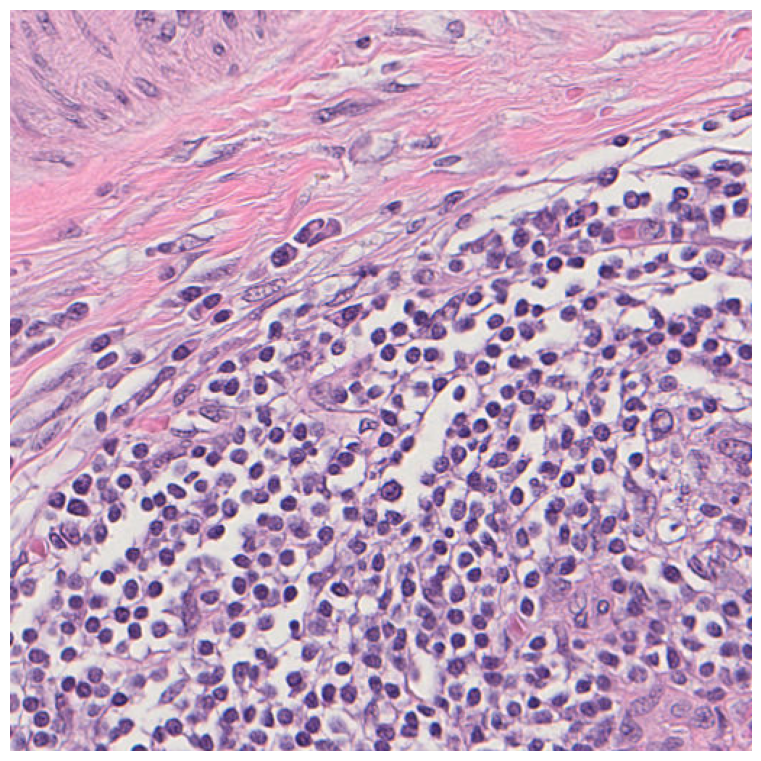

In [59]:
show_tile(HE_20x_tile)

In [60]:
centroids = [nuc['centroid'] for nuc in segmentation_data]
contours = [nuc['contour'] for nuc in segmentation_data]
print(len(centroids))
print(len(contours))

355861
355861


In [61]:
# I'm going to offset the coordinates of the segmentation data by the cropping x,y coords now for easy display
adj_centroids = [[pair[0][0] - crop_data[1], pair[0][1] - crop_data[0]] for pair in centroids]
centroids_in_tile = [pair for pair in adj_centroids if 0 < pair[1] < crop_data[3] and 0 < pair[0] < crop_data[2]]

In [62]:
def show_tile_centroids_overlay(tile, centroids=None, **kwargs):
    """Plot a single image with optional centroids overlay."""
    fig, ax = plt.subplots(1,2, figsize=(16, 8))
    
    ax[0].imshow(tile)
    
    # Show the image
    ax[1].imshow(tile, **kwargs)
    
    # Overlay centroids if provided
    if centroids:
        centroids = list(map(list, zip(*centroids)))  # Transpose the centroids list
        ax[1].scatter(centroids[1], centroids[0], marker='o', color='red', s=50, label='Centroids')
    
    plt.tight_layout()
    ax[0].set_axis_off()
    
    # Show the legend if centroids are present
    if centroids:
        ax[1].legend()
    
    ax[1].set_axis_off()
    
    plt.show()

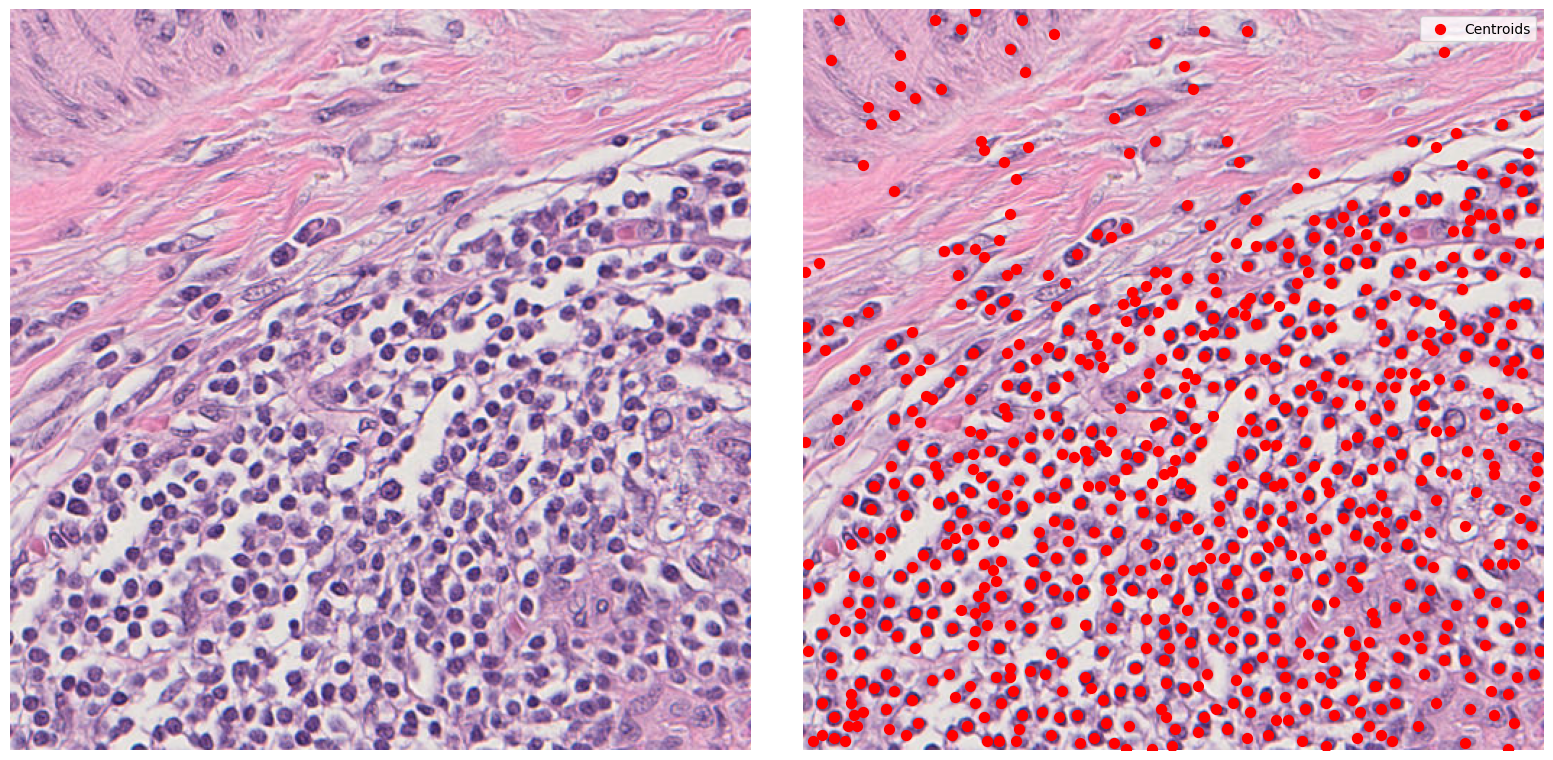

In [63]:
show_tile_centroids_overlay(HE_20x_tile, centroids=centroids_in_tile)

Load in qupath selected nuclei (geojson file), next step is to show those centroids in the tile here

In [64]:
geojson_file = r'\\10.99.68.178\andreex\students\Donald Monkey fetus\BTC\qupath\geojson\H15_0277_v2.geojson'
geo_data = json.load(open(geojson_file))
print(geo_data.keys())

dict_keys(['type', 'features'])


In [65]:
centroids_ann = []

for i in range(len(geo_data['features'])):
    data = geo_data['features'][i]
    coords = data['geometry']['coordinates'][0]
    
    x_cent = 0
    y_cent = 0
    for pair in coords:
        x_cent += pair[1]
        y_cent += pair[0]
    x_cent /= len(coords)
    y_cent /= len(coords)
    
    # print(x_cent, y_cent)
    centroids_ann.append([x_cent, y_cent])

In [66]:
# again, adjust centroid coordinates by crop x,y data to display fast and easy
adj_centroids = [[pair[0] - crop_data[1], pair[1] - crop_data[0]] for pair in centroids_ann]
centroids_in_tile_ann = [pair for pair in adj_centroids if 0 < pair[1] < crop_data[3] and 0 < pair[0] < crop_data[2]]

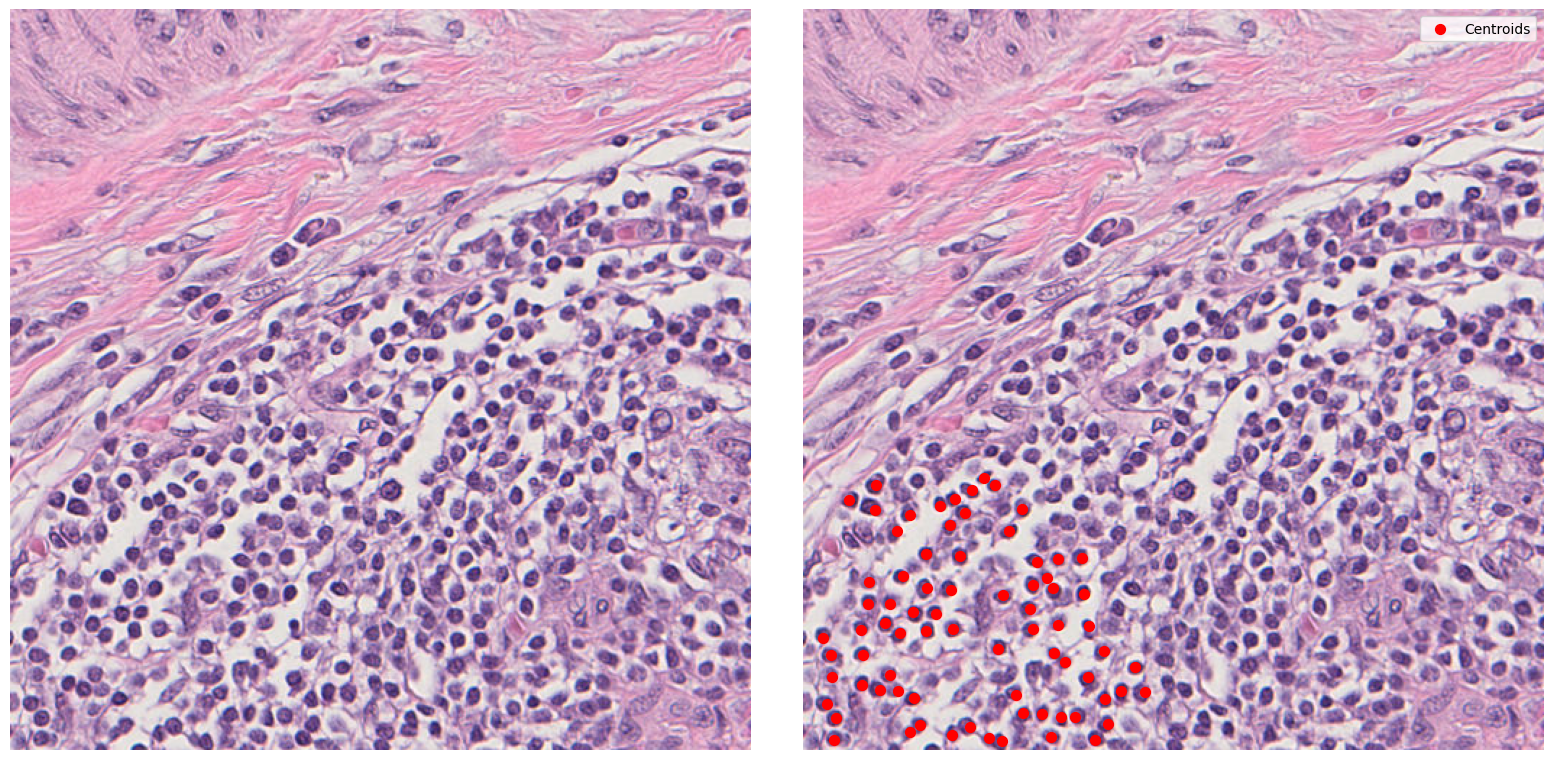

In [67]:
show_tile_centroids_overlay(HE_20x_tile, centroids=centroids_in_tile_ann)

In [68]:
# fix format of stardist centroids list

centroids2 = [centroid[0] for centroid in centroids]
print(centroids2[:5])

[[3278, 1806], [1184, 3666], [1460, 6102], [3164, 5622], [2760, 5706]]


In [69]:
print(f'Number of  annotated: {len(centroids_in_tile_ann)}')
print(f'Number of centroids total: {len(centroids2)}')

Number of  annotated: 76
Number of centroids total: 355861


In [70]:
centroids_ann_np = np.array(centroids_ann)
centroids_total_np = np.array(centroids2)

In [71]:
# https://stackoverflow.com/questions/71027729/finding-optimal-nearest-neighbour-pairs

# match closest pairs of coordinates in two sets of x,y coordinates

import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix, csgraph

def colocalize_points(points_a: np.ndarray, points_b: np.ndarray, r: int):
    """ Find pairs that minimize global distance. Filters out anything outside radius `r` """

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(points_b)
    distances, b_indices = neigh.radius_neighbors(points_a, radius=r)

    # flatten and get indices for A. This will also drop points in A with no matches in range
    d_flat = np.hstack(distances) + 1
    b_flat = np.hstack(b_indices)
    a_flat = np.array([i for i, neighbors in enumerate(distances) for n in neighbors])

    # filter out A points that cannot be matched
    sm = csr_matrix((d_flat, (a_flat, b_flat)))
    a_matchable = csgraph.maximum_bipartite_matching(sm, perm_type='column')
    sm_filtered = sm[a_matchable != -1]

    # now run the distance minimizing matching
    row_match, col_match = csgraph.min_weight_full_bipartite_matching(sm_filtered)
    return row_match, col_match

In [72]:
results = colocalize_points(centroids_ann_np, centroids_total_np, r=20)

In [73]:
centroids_annotated = [centroids_ann_np[i] for i in results[0]]
print(centroids_annotated[:5])

[array([34588.57894737, 34090.10526316]), array([34588.57142857, 34068.23809524]), array([34576.81818182, 34062.59090909]), array([34576.16, 34045.6 ]), array([34593.48, 34034.44])]


In [74]:
centroids_all = [centroids_total_np[i] for i in results[1]]
print(centroids_all[:5])

[array([34588, 34088]), array([34590, 34068]), array([34574, 34062]), array([34578, 34046]), array([34592, 34034])]


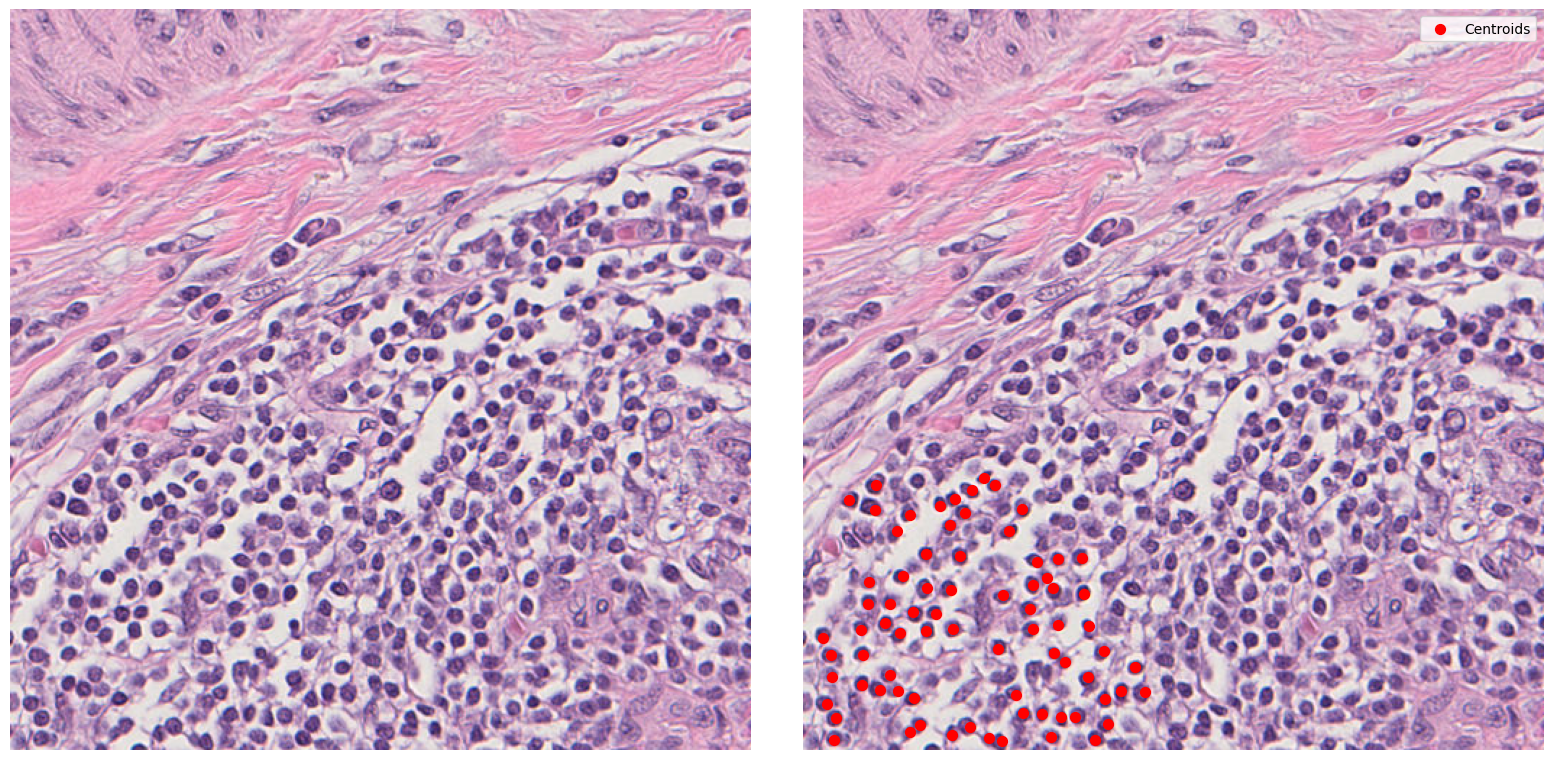

In [75]:
# plot same thing as we last did, but this time we are using the true centroids from stardist segmentation, not our annotated qupath centroids, this is possible by our colocalize_points function that I copied from stackoverflow

adj_centroids = [[pair[0] - crop_data[1], pair[1] - crop_data[0]] for pair in centroids_annotated]
centroids_in_tile_ann = [pair for pair in adj_centroids if 0 < pair[1] < crop_data[3] and 0 < pair[0] < crop_data[2]]
show_tile_centroids_overlay(HE_20x_tile, centroids=centroids_in_tile_ann)

Now I want to get the contours of those nuclei and plot them

In [76]:
# adjust the coordinates of the segmentation data to fit cropped region

centroids_matched = [pair.tolist() for pair in centroids_all]

adj_centroids_matched = [[pair[0] - crop_data[1], pair[1] - crop_data[0]] for pair in centroids_matched]

adj_centroids = [[pair[0] - crop_data[1], pair[1] - crop_data[0]] for pair in centroids2]
centroids_in_tile_seg = [pair for pair in adj_centroids if 0 < pair[1] < crop_data[3] and 0 < pair[0] < crop_data[2] and pair not in adj_centroids_matched]

In [77]:
# get indices of those matched coordinates within the list of all of the centroids/contours from stardist

indices_matched = [adj_centroids.index(pair) for pair in adj_centroids if pair in adj_centroids_matched]

indices_not_matched = [adj_centroids.index(pair) for pair in adj_centroids if 0 < pair[1] < crop_data[3] and 0 < pair[0] < crop_data[2] and pair not in adj_centroids_matched]  # and within crop range

print(len(indices_matched))
print(len(indices_not_matched))

138
685


In [78]:
contours_matched = [contours[i] for i in indices_matched]
contours_not_matched = [contours[i] for i in indices_not_matched] 

# now I have contours that I want

In [79]:
# adjust contours by x,y crop data

contours_matched_adjusted = []
for i in range(len(contours_matched)):
    contour = contours_matched[i][0]
    x_coords = contour[0]
    y_coords = contour[1]
    x_coords = [point-crop_data[1] for point in x_coords]
    y_coords = [point-crop_data[0] for point in y_coords]
    
    shape = list(zip(x_coords, y_coords))
    contours_matched_adjusted.append(shape)

contours_not_matched_adjusted = []
for i in range(len(contours_not_matched)):
    contour = contours_not_matched[i][0]
    x_coords = contour[0]
    y_coords = contour[1]
    x_coords = [point-crop_data[1] for point in x_coords]
    y_coords = [point-crop_data[0] for point in y_coords]
    
    shape = list(zip(x_coords, y_coords))
    contours_not_matched_adjusted.append(shape)

Now I'm just gonna read the ndpi file instead of doing all this stuff with cropping I think

In [88]:
npdi_im_path = r'\\10.99.68.178\andreex\students\Donald Monkey fetus\BTC\ndpi'

im_list = os.listdir(npdi_im_path)
im_list = [im for im in im_list if im.endswith('.ndpi')]

ind = 0

HE_20x_WSI = imread(os.path.join(npdi_im_path, im_list[ind]))

In [89]:
print(crop_data)

(34049, 34143, 512, 512)


In [124]:
crop_x = crop_data[0] - 100
crop_y = crop_data[1] + 200
tile_size = crop_data[2]

In [125]:
HE_20x_tile = HE_20x_WSI[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

In [126]:
centroids_matched = [pair.tolist() for pair in centroids_all]

adj_centroids_matched = [[pair[0] - crop_y, pair[1] - crop_x] for pair in centroids_matched]

adj_centroids = [[pair[0] - crop_y, pair[1] - crop_x] for pair in centroids2]
centroids_in_tile_seg = [pair for pair in adj_centroids if 0 < crop_y < tile_size and 0 < crop_x < tile_size and pair not in adj_centroids_matched]

indices_matched = [adj_centroids.index(pair) for pair in adj_centroids if pair in adj_centroids_matched]

indices_not_matched = [adj_centroids.index(pair) for pair in adj_centroids if 0 < pair[1] < tile_size and 0 < pair[0] < tile_size and pair not in adj_centroids_matched]  # and within crop range

print(len(indices_matched))
print(len(indices_not_matched))

138
796


In [127]:
def adjust_contours(contours_matched, x, y):

    contours_matched_adjusted = []
    for i in range(len(contours_matched)):
        contour = contours_matched[i][0]
        x_coords = contour[0]
        y_coords = contour[1]
        x_coords = [point-x for point in x_coords]
        y_coords = [point-y for point in y_coords]
        
        shape = list(zip(x_coords, y_coords))
        contours_matched_adjusted.append(shape)
    
    return contours_matched_adjusted

In [130]:
contours_matched = [contours[i] for i in indices_matched]
contours_not_matched = [contours[i] for i in indices_not_matched] 

contours_matched_adjusted = adjust_contours(contours_matched, crop_y, crop_x)
contours_not_matched_adjusted = adjust_contours(contours_not_matched, crop_y, crop_x)

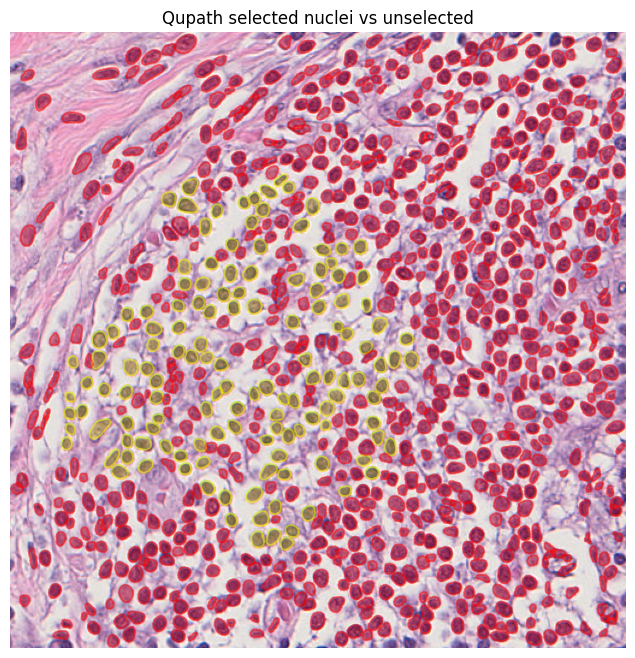

In [131]:
reversed_contours = [[(y, x) for x, y in polygon] for polygon in contours_matched_adjusted]

reversed_contours_negative = [[(y, x) for x, y in polygon] for polygon in contours_not_matched_adjusted]

fig, ax = plt.subplots(figsize=(16, 8))

# Plot the image
ax.imshow(HE_20x_tile)
ax.set_axis_off()

# Plot each reversed polygon on the same image
for polygon in reversed_contours:
    x_coords, y_coords = zip(*polygon)
    x_coords = list(x_coords) + [x_coords[0]]  # Close the polygon
    y_coords = list(y_coords) + [y_coords[0]]  # Close the polygon

    color = 'yellow'

    ax.plot(x_coords, y_coords, alpha=0.3, color=color)
    ax.fill(x_coords, y_coords, alpha=0.3, color=color)  # Fill the polygon
    
# Plot each reversed polygon on the same image
for polygon in reversed_contours_negative:
    x_coords, y_coords = zip(*polygon)
    x_coords = list(x_coords) + [x_coords[0]]  # Close the polygon
    y_coords = list(y_coords) + [y_coords[0]]  # Close the polygon

    color = 'red'
    
    skip = False
    for x in x_coords:
        if x < 0 or x > (tile_size - 1):
            skip = True
            break
    for y in y_coords:
        if y < 0 or y > (tile_size - 1):
            skip = True
            break
    
    if not skip:

        ax.plot(x_coords, y_coords, alpha=0.3, color=color)
        ax.fill(x_coords, y_coords, alpha=0.3, color=color)  # Fill the polygon

# Set labels and title for the plot
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Qupath selected nuclei vs unselected')

plt.show()